In [1]:
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

In [163]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

In [52]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [28]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Create only one feature - “flight” (this you need to improve - add more features)

In [165]:
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,flight
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N,ATL-->DFW
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N,PIT-->MCO
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N,RDU-->CLE
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N,DEN-->MEM
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y,MDW-->OMA


Remember indexes of categorical features (to be passed to CatBoost)`

In [6]:
categ_feat_idx = np.where(train_df.drop('dep_delayed_15min', axis=1).dtypes == 'object')[0]
categ_feat_idx

array([0, 1, 2, 4, 5, 6, 8], dtype=int64)

Allocate a hold-out set (a.k.a. a validation set) to validate the model

In [202]:
X_train = train_df.drop('dep_delayed_15min', axis=1).values
y_train = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test_df.values

In [151]:
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

Train Catboost with default arguments, passing only the indexes of categorical features.

In [9]:
ctb = CatBoostClassifier(random_seed=17, silent=True)

In [10]:
%%time
ctb.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);

Wall time: 1min 35s


In [11]:
ctb_valid_pred = ctb.predict_proba(X_valid)[:, 1]

We got some 0.756 ROC AUC on the hold-out set.

In [12]:
roc_auc_score(y_valid, ctb_valid_pred)

0.7573957036518252

Train on the whole train set, make prediction on the test set. We got ~0.734 in the competition - "Catboost starter" baseline

In [13]:
%%time
ctb.fit(X_train, y_train,
        cat_features=categ_feat_idx);

Wall time: 1min 55s


In [56]:
ctb_test_pred = ctb.predict_proba(X_test)[:, 1]


In [60]:
print(ctb_test_pred)

[0.04279487 0.0706864  0.04378987 ... 0.29030999 0.0955812  0.07320605]


In [61]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col='id')
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sample_sub.to_csv('ctb_pred.csv')

In [63]:
sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col='id')
sample_sub['dep_delayed_15min'] = ctb_test_pred
sample_sub.to_csv(PATH_TO_DATA /'ctb_pred.csv')

In [54]:
!head ctb_pred.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


Подрубим GPU

Сначала запомним время работы на CPU:

    part - Wall time: 1min 35s
    
    full - Wall time: 1min 55s
    
Теперь пора подрубать GPU

Training with GPU is easy:

- turn on GPU in the Notebook settings - bottom right (here it's already turned on)
- add argument task_type='GPU' when initializing CatBoostClassifier
- be careful with weekly 30 hours GPU quotas when using Kaggle Notebooks

In [64]:
ctb_gpu = CatBoostClassifier(random_seed=17, silent=True, task_type='GPU')

In [65]:
%%time
ctb_gpu.fit(X_train_part, y_train_part,
        cat_features=categ_feat_idx);

Wall time: 2min


In [66]:
ctb_gpu_valid_pred = ctb.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, ctb_gpu_valid_pred)

0.870384644609272

In [67]:
%%time
ctb_gpu.fit(X_train, y_train,
        cat_features=categ_feat_idx);

Wall time: 1min 16s


In [68]:
ctb_gpu_valid_pred = ctb.predict_proba(X_valid)[:, 1]
roc_auc_score(y_valid, ctb_gpu_valid_pred)

0.870384644609272

Результаты очень высокие... Переобучился?

Как бы то ни было, попробуем выгрузить и закинуть на kagle

In [199]:
X_test.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [72]:
ctb_gpu_test_pred = ctb_gpu.predict_proba(X_test)[:, 1]
sample_sub2 = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col='id')
sample_sub2['dep_delayed_15min'] = ctb_gpu_test_pred
sample_sub2.to_csv(PATH_TO_DATA /'ctb_gpu_pred.csv')

# <center> Окей, самое время позаниматься фича-инженерингом

Необходимо:
- На Кегле взять 0.75914

Текущий лучший результат:
- при обучение на трейн.парт и проверке на отложенных - 0.7847049105500216
- при обучение на фул и проверке на фул - 0.9757270394048421
- тестовые данные на Кегле -0.74944
- Параметры: Добавление flight, hour, minute, summer, autumn, winter, sping. Вроде без DayTime, String to numerical, 
LabelEncoding


Улучшил до:
- 79.4... на отложенных.

Добавился тюнинг параметров, оптимальные - 10 глубина и 3 регуляризация
use_best_model=True, 
                             task_type='GPU', border_count = 254

После допила параметров 

Пока так. Сезоны 1й фичей, нет выходных и тру-фолс на долгие полеты
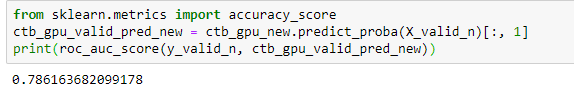

In [506]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

from tqdm import tqdm
from sklearn.grid_search import ParameterGrid
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.grid_search import ParameterGrid
from sklearn.model_selection import train_test_split
from itertools import product, chain
from tqdm import tqdm




In [507]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')
train_df_new = train_df.copy()
test_df_new = test_df.copy()
train_split = train_df.shape[0]
df_full = pd.concat((train_df, test_df))

In [508]:
# flight
df_full['flight'] = df_full['Origin'] + '-->' + df_full['Dest']
# Hour and minute
df_full['hour'] = df_full['DepTime'] // 100
df_full.loc[df_full['hour'] == 24, 'hour'] = 0
df_full.loc[df_full['hour'] == 25, 'hour'] = 1
df_full['minute'] = df_full['DepTime'] % 100
df_full.head()

,DayOfWeek,DayofMonth,DepTime,Dest,Distance,Month,Origin,UniqueCarrier,dep_delayed_15min,flight,hour,minute
0,c-7,c-21,1934,DFW,732,c-8,ATL,AA,N,ATL-->DFW,19,34
1,c-3,c-20,1548,MCO,834,c-4,PIT,US,N,PIT-->MCO,15,48
2,c-5,c-2,1422,CLE,416,c-9,RDU,XE,N,RDU-->CLE,14,22
3,c-6,c-25,1015,MEM,872,c-11,DEN,OO,N,DEN-->MEM,10,15
4,c-6,c-7,1828,OMA,423,c-10,MDW,WN,Y,MDW-->OMA,18,28


In [509]:
# Season
# one-hot кодирование сезона. Нахуй? Лучше наверное иначе
df_full['summer'] = (df_full['Month'].isin(['c-6', 'c-7', 'c-8'])).astype(np.int32)
df_full['autumn'] = (df_full['Month'].isin(['c-9', 'c-10', 'c-11'])).astype(np.int32)
df_full['winter'] = (df_full['Month'].isin(['c-12', 'c-1', 'c-2'])).astype(np.int32)
df_full['spring'] = (df_full['Month'].isin(['c-3', 'c-4', 'c-5'])).astype(np.int32)



In [510]:
# String to numerical
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    df_full[col] = df_full[col].apply(lambda x: x.split('-')[1]).astype(np.int32)

In [511]:
# Seasons
df_full['season'] = df_full['Month'].map({12 : 1, 1 : 1,2 : 1, 
                                          3  : 2, 4  : 2,5  : 2,
                                          6: 3, 7: 3, 8: 3, 
                                          9 : 4, 10 : 4, 11 : 4}).astype(np.int32) 

In [512]:
# WeekEnds
df_full['WeekEnds'] = df_full['DayOfWeek'].map({6 : 0, 2 : 0,3 : 0, 4:0, 5:0 ,
                                           1 : 1,7  : 1,}).astype(np.int32) 


In [513]:
# hour_flag_2
df_full['Dep_hour_flag'] = ((df_full['hour'] >= 15) & (df_full['hour'] < 23)).astype('int')


In [514]:
# hour_flag_2
#df_full['Dep_hour_flag_2'] = ((df_full['hour'] >= 6) & (df_full['hour'] < 23)).astype('int')


In [515]:
df_full['other_time'] = ((df_full['hour'] < 9) & (df_full['hour'] >=5)).astype('int')
df_full['middle_time'] = ((df_full['hour'] >= 9) & (df_full['hour'] < 13)).astype('int')

In [516]:
df_full['morning'] = ((df_full['hour'] >= 6) & (df_full['hour'] < 12)).astype('int')
df_full['day'] = ((df_full['hour'] >= 12) & (df_full['hour'] < 18)).astype('int')
df_full['evening'] = ((df_full['hour'] >= 18) & (df_full['hour'] < 24)).astype('int')
#df_full['night'] = ((df_full['hour'] >= 0) & (df_full['hour'] < 6)).astype('int')

In [517]:
df_full.drop(['dep_delayed_15min'], axis = 1).head()

,DayOfWeek,DayofMonth,DepTime,Dest,Distance,Month,Origin,UniqueCarrier,flight,hour,...,winter,spring,season,WeekEnds,Dep_hour_flag,other_time,middle_time,morning,day,evening
0,7,21,1934,DFW,732,8,ATL,AA,ATL-->DFW,19,...,0,0,3,1,1,0,0,0,0,1
1,3,20,1548,MCO,834,4,PIT,US,PIT-->MCO,15,...,0,1,2,0,1,0,0,0,1,0
2,5,2,1422,CLE,416,9,RDU,XE,RDU-->CLE,14,...,0,0,4,0,0,0,0,0,1,0
3,6,25,1015,MEM,872,11,DEN,OO,DEN-->MEM,10,...,0,0,4,0,0,0,1,1,0,0
4,6,7,1828,OMA,423,10,MDW,WN,MDW-->OMA,18,...,0,0,4,0,1,0,0,0,0,1


In [518]:
# df_full['night'].unique()

In [520]:
# df_full['night'].value_counts()

<h2> Поделим выборку

In [521]:
train_df, test_df = df_full.iloc[:train_split], df_full.iloc[train_split:]
X_train_new = train_df.drop('dep_delayed_15min', axis=1).values
y_train_new = train_df['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_train_part_n, X_valid_n, y_train_part_n, y_valid_n = train_test_split(X_train_new, y_train_new, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [522]:
print(len(X_train_part_n[1,:]))
X_train_part_n[0,:]


23


array([1, 18, 1148, 'MEM', 559, 4, 'AUS', 'NW', 'AUS-->MEM', 11, 48, 0, 0,
       0, 1, 2, 1, 0, 0, 1, 1, 0, 0], dtype=object)

Посмотрим какие значения классы, а какие - нет. Из новых в частности

In [523]:
#categ_feat_idx_new = np.where(df_full.dtypes == 'object')[0]
categ_feat_idx_new = [0, 1, 3, 4, 6, 7, 8, 9, 10,11,12,13,
                     14,15,16,17,18,19,20,21,22]

In [524]:
ctb = CatBoostClassifier(random_seed=17, silent=True, task_type='GPU', 
                         border_count = 254,
                         depth = 10,
                        l2_leaf_reg = 3
                        )

In [500]:
X_train_part_n[0,3]

'MEM'

In [525]:
%%time
ctb.fit(X_train_part_n, y_train_part_n,
        cat_features=categ_feat_idx_new);

Wall time: 3min 9s


In [526]:
valid_pred = ctb.predict_proba(X_valid_n)[:, 1]
print(roc_auc_score(y_valid_n, valid_pred))

0.780993193891313


In [527]:
ctb.get_feature_importance()

[8.090341458776399,
 8.98153983397675,
 7.634526115533117,
 7.147781694857064,
 5.850041000557492,
 4.344986026400603,
 8.496605820453585,
 11.105079361969539,
 6.781852891578155,
 11.735608442621091,
 10.076193039454749,
 0.30329251102565064,
 0.11831007509138738,
 0.16724420273752896,
 0.09773923170138378,
 6.596404316418229,
 0.5171968875047958,
 0.22893212673075966,
 0.3522562003279323,
 0.19201800739174119,
 0.025118551199056857,
 0.984640674221543,
 0.1722915294714524]

In [528]:
%%time
ctb.fit(X_train_new, y_train_new,
        cat_features=categ_feat_idx_new);

Wall time: 3min 28s


In [529]:
valid_pred = ctb.predict_proba(X_valid_n)[:, 1]
print(roc_auc_score(y_valid_n, valid_pred))

0.9634108631159904


In [530]:
test =  test_df.drop('dep_delayed_15min', axis=1).values
test.shape,X_train_new.shape

((100000, 23), (100000, 23))

Выводы

In [532]:
# применение в действие
ctb_v6_pred = ctb.predict_proba(X_test)[:, 1]
sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col='id')
sample_sub['dep_delayed_15min'] = ctb_v6_pred
sample_sub.to_csv(PATH_TO_DATA /'ctb_v6.csv')

CatboostError: Invalid cat_features[13] = 15 value: must be < 15.

[1.00000000e-20 3.16227766e-20 1.00000000e-19]


Дальнейшие возможности по улучшению полученной тюнингом параметров модели:<br>
- Добавить фичу выходной/нет
- Добавить фичу с интервалами работы
- Добавить фичу с очень дальними расстояниями?

Дерево с затюнеными параметрами

In [98]:
clf = CatBoostClassifier(leaf_estimation_iterations = 10,
                             task_type='GPU', 
                             border_count = 254)   
#уже готово, заменить
X_train, y_train = X_train_new, y_train_new
X_test = test_df.drop('dep_delayed_15min', axis=1).values
# разбитие выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, shuffle=True, random_state=RANDOM_STATE, 
                                                          train_size=0.8,stratify=y_train)
# обучение
clf.fit(X_train, y_train, cat_features=categ_feat_idx_new, logging_level='Silent',
            eval_set=(X_valid, y_valid)
)
    
# результаты дерева после тюнинга параметров
y_pred = clf.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred)
print('Результаты после тюнинга параметров: ', roc_auc)
    


Результаты после тюнинга параметров:  0.7970412403819663


In [100]:
# применение в действие
ctb_v3_pred = clf.predict_proba(X_test)[:, 1]
sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv', index_col='id')
sample_sub['dep_delayed_15min'] = ctb_v3_pred
sample_sub.to_csv(PATH_TO_DATA /'ctb_v3.csv')